####  Bogumiła Walkowiak bogumila.walkowiak@grenoble-inp.org

#### Joachim Mąkowski joachim-kajetan.makowski@grenoble-inp.org

# Intelligent Systems: Reasoning and Recognition
## Recognizing Digits using Neural Networks

## 1. Introduction

<font size=4>The MNIST (Modified National Institute of Standards and Technology) dataset is a large collection of handwritten digits composed of 60,000 training images and 10,000 test images. The black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced gray-scale levels. Our task was to design and evaluate neural network architectures that can recognize hand-drawn digits using the grayscale this data set.

## 2. Data preparation

<font size=4>First of all, we downloaded MNIST data. We decided to combine train and test set provided by MNIST dataset and then we splited data into training set 90% and a test set 10%. In the further part of the project, we'll also create a validation set so the final split of the data will look like this: training data 80%, validating data 10% and testing data 10%.

In [86]:
import numpy as np
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_curve,auc

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [95]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #loading the data set

In [96]:
X = np.concatenate((x_train, x_test)) 
y = np.concatenate([y_train, y_test])

In [97]:
train_ratio = 0.9 
test_ratio = 0.1

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio)

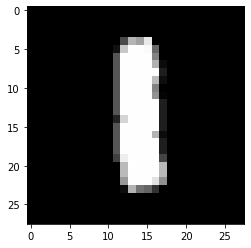

In [98]:
plt.imshow(x_train[0], cmap='gray')

In [99]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [100]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## 3. Creating neural networks

<font size=4>We decided to create a function. Thanks to it we will be able to write less code. Function trains model provided by argument of function, prints model's loss, accuracy, precision, recall and AUC for each digit and plots a history of training.

In [60]:
def predict_model(model, callbacks = [],batch_size=128, epochs = 4,lr=0.001):
    adam = keras.optimizers.Adam(lr=lr)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy", "Precision","Recall"])

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.11, callbacks=callbacks)
    score = model.evaluate(x_test, y_test, verbose=0)
    y_pred = model.predict(x_test)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    print("Test precision:", score[2])
    print("Test recall:", score[3])
    
    y_pred = np.argmax(y_pred,axis=1)
    y_test1 = np.argmax(y_test,axis=1)
    
    print("Test f1 score:", f1_score(y_test1,y_pred,average='micro'))
    for i in range(10):
        temp_pred = [1 if x==i else 0 for x in y_pred]
        temp_test = [1 if x==i else 0 for x in y_test1]
        fpr, tpr, thresholds =roc_curve(temp_test,temp_pred)

        print("Test AUC for digit:",i, auc(fpr, tpr))
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

<font size=4>We added an instance of EarlyStopping class, which provides us a mechanism of stopping algorithm before the whole training process is done. When 3 epochs are not achieving a better result (in our example higher validation accuracy) then our training is stopped and we restore the best model.

In [61]:
# simple early stopping
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 3, restore_best_weights=True)

### Basic Fully Connected Multi-layer Network

<font size=4>The first network we have created is basic fully connected mutli-layer network:

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 28, 28, 32)        64        
_________________________________________________________________
dense_60 (Dense)             (None, 28, 28, 64)        2112      
_________________________________________________________________
flatten_20 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 10)                1290      
Total params: 6,426,122
Trainable params: 6,426,122
Non-trainable params: 0
___________________________________________

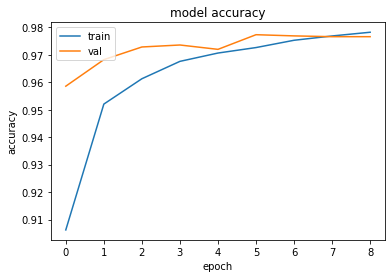

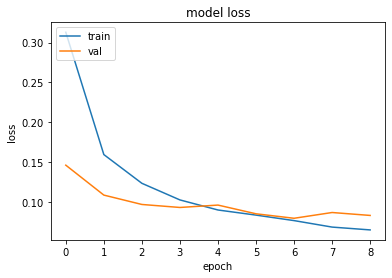

In [48]:
model_fc = keras.Sequential([
    layers.Dense(32, activation="relu",input_shape=(28,28,1)),
    layers.Dense(64, activation="relu"),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc.summary()
predict_model(model_fc, [es], epochs=100)

<font size=4>This is basic model achieves about 97,5% accuracy on test set. It is made of 2 hidden layers with reasonable number of units. Training this model is quite fast (on my laptop it was 5s per epoch, using GPU).
As we see in plots our model started to overfits, because validation accuracy and loss was staying on the same level, while train accuracy was growing and loss was decreasing.

<font size=4>Next, we wanted to demonstrate the effect of changing various parameters of the network.

### Different number of layers

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 1,606,410
Trainable params: 1,606,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
439/439 [==============================] - 11s 22ms/step - loss: 0.5918 - accuracy: 0.8171 - preci

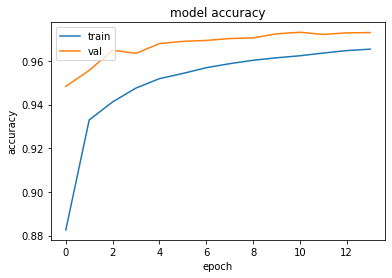

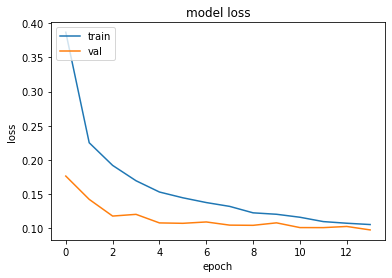

In [13]:
model_fc_small = keras.Sequential([
    layers.Dense(32, activation="relu",input_shape=(28,28,1)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc_small.summary()
predict_model(model_fc_small, [es], epochs=100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
dense_8 (Dense)              (None, 28, 28, 64)        2112      
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              205524992 
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                65600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

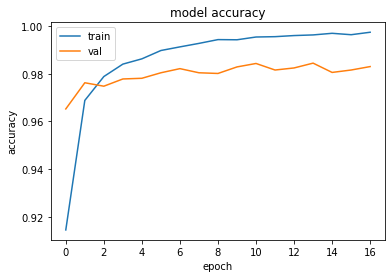

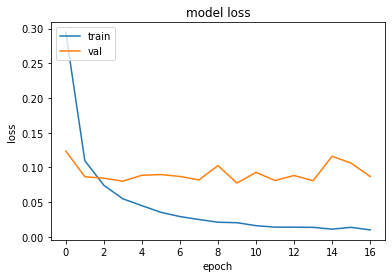

In [14]:
model_fc_large = keras.Sequential([
    layers.Dense(32, activation="relu",input_shape=(28,28,1)),
    layers.Dense(64, activation="relu"),
    layers.Flatten(),
    layers.Dense(4096, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc_large.summary()
predict_model(model_fc_large, [es], epochs=100)

<font size=4>Firstly, we tried different numbers of hidden layers. With 1 hidden layer the model the model was achieving around 96,5% on test set. The model is underfitted because this number of layers is not enough to explain the complexity of our data.

Model with 4 hidden layers achieved 98,1% of accuracy but the training time was pretty long (34s per epoch). That is because this model had to find weights for over 200,000,000 parameters (compering to 1,600,000 of params for model with 1 hidden layer). We can assume, that after second epoch our model is overfitted because the difference between validation and train loss and accuracy are high.

### Different number of units per layer

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 28, 28, 10)        20        
_________________________________________________________________
dense_14 (Dense)             (None, 28, 28, 20)        220       
_________________________________________________________________
flatten_3 (Flatten)          (None, 15680)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 40)                627240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                410       
Total params: 627,890
Trainable params: 627,890
Non-trainable params: 0
________________________________________________

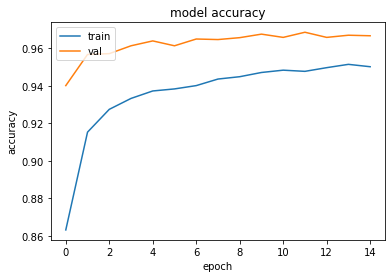

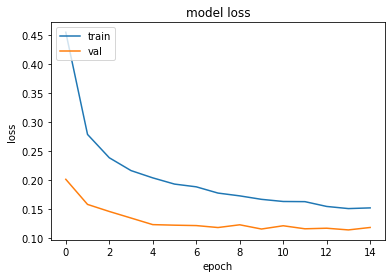

In [15]:
model_fc = keras.Sequential([
    layers.Dense(10, activation="relu",input_shape=(28,28,1)),
    layers.Dense(20, activation="relu"),
    
    layers.Flatten(),
    layers.Dense(40, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc.summary()
predict_model(model_fc, [es], epochs=100)

<font size=4>In this situation we trained a model with small number of units in each layer. The model didn't achieve it's best. We can see, that train accuracy is much lower than validation accuracy. It is caused by insufficient number of units, so that our model decided to choose higher accuracy in validation data at the expense of accuracy on whole data.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 28, 28, 100)       200       
_________________________________________________________________
dense_18 (Dense)             (None, 28, 28, 200)       20200     
_________________________________________________________________
flatten_4 (Flatten)          (None, 156800)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 400)               62720400  
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                4010      
Total params: 62,744,810
Trainable params: 62,744,810
Non-trainable params: 0
__________________________________________

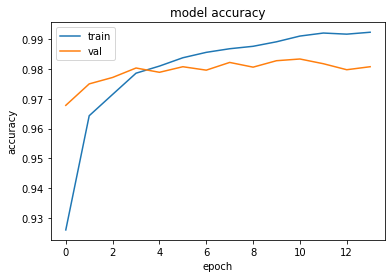

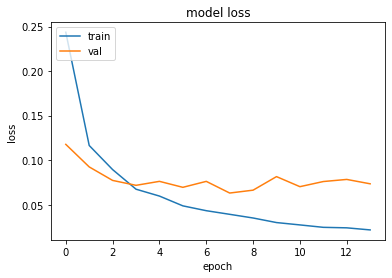

In [16]:
model_fc = keras.Sequential([
    layers.Dense(100, activation="relu",input_shape=(28,28,1)),
    layers.Dense(200, activation="relu"),
    
    layers.Flatten(),
    layers.Dense(400, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc.summary()
predict_model(model_fc, [es], epochs=100)

<font size=4>In this model we see that it's overfitting after third epoch. It is caused by too high number of units.

### Different learning rate

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 28, 28, 32)        64        
_________________________________________________________________
dense_64 (Dense)             (None, 28, 28, 64)        2112      
_________________________________________________________________
flatten_21 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 10)                1290      
Total params: 6,426,122
Trainable params: 6,426,122
Non-trainable params: 0
___________________________________________

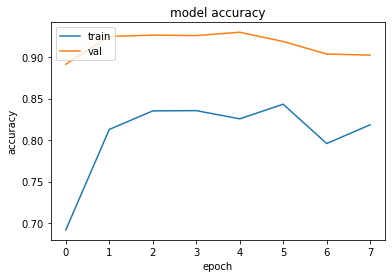

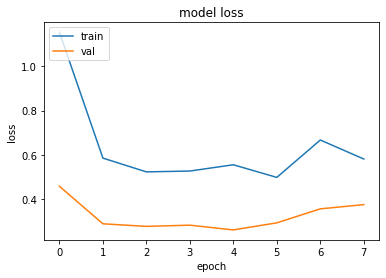

In [49]:
model_fc_01 = keras.Sequential([
    layers.Dense(32, activation="relu",input_shape=(28,28,1)),
    layers.Dense(64, activation="relu"),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc_01.summary()
predict_model(model_fc_01,[es], epochs=100, lr=0.05)

<font size=4>We took our first model and decided to train it with different learning rates. With learning rate 0.05 we received very bad results (accuracy around 92%). The scores are so bad because our optimizer did not find good weights, because it had to change values with too big "jump".

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 28, 28, 32)        64        
_________________________________________________________________
dense_47 (Dense)             (None, 28, 28, 64)        2112      
_________________________________________________________________
flatten_15 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                1290      
Total params: 6,426,122
Trainable params: 6,426,122
Non-trainable params: 0
___________________________________________

439/439 [==============================] - 5s 12ms/step - loss: 0.1395 - accuracy: 0.9596 - precision: 0.9680 - recall: 0.9526 - val_loss: 0.1241 - val_accuracy: 0.9645 - val_precision: 0.9722 - val_recall: 0.9595
Epoch 33/100
439/439 [==============================] - 5s 12ms/step - loss: 0.1311 - accuracy: 0.9620 - precision: 0.9695 - recall: 0.9547 - val_loss: 0.1213 - val_accuracy: 0.9659 - val_precision: 0.9721 - val_recall: 0.9609
Epoch 34/100
439/439 [==============================] - 5s 12ms/step - loss: 0.1297 - accuracy: 0.9622 - precision: 0.9695 - recall: 0.9555 - val_loss: 0.1186 - val_accuracy: 0.9649 - val_precision: 0.9721 - val_recall: 0.9605
Epoch 35/100
439/439 [==============================] - 5s 12ms/step - loss: 0.1279 - accuracy: 0.9621 - precision: 0.9696 - recall: 0.9551 - val_loss: 0.1162 - val_accuracy: 0.9668 - val_precision: 0.9726 - val_recall: 0.9629
Epoch 36/100
439/439 [==============================] - 5s 12ms/step - loss: 0.1146 - accuracy: 0.9653 - 

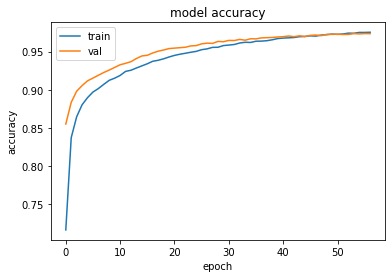

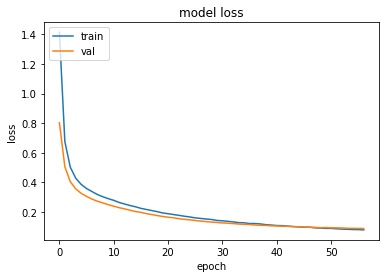

In [39]:
model_fc_00001 = keras.Sequential([
    layers.Dense(32, activation="relu",input_shape=(28,28,1)),
    layers.Dense(64, activation="relu"),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
]) 
model_fc_00001.summary()
predict_model(model_fc_00001,[es], epochs=100, lr = 0.00001)

<font size=4>Model with learning rate equals 0.00001 performed pretty well but it needed 54 epochs to achieve 97,1% accuracy (compared to 6 epochs using standard learning rate equals 0.001). This is because optimizer "jumped" too small distance searching best results, and it had to do many iterations to find the best weights.

### Basic Multi-layer CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)               

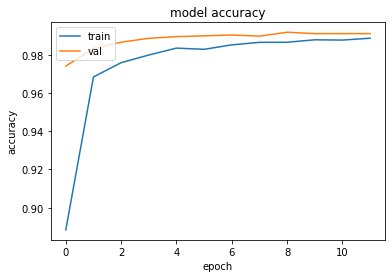

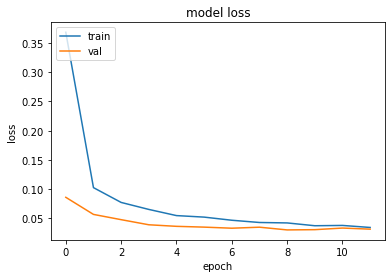

In [17]:
model_cnn = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D (2,2),  
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D (2,2),   

    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn.summary()
predict_model(model_cnn, [es], epochs=100)

<font size=4>Our first convolutional model with 2 convolutional layers was performing even better then fully connected neural networks. This model is not overfitted, because train and validation loss and accuracy are close to each other. It has only 34,826 parameters to train, so the training of such model is pretty fast. On test set model achieves 98.7% accuracy which is great result.

### Different number of convolutional layers

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5408)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
439/439 [==============================] - 4s 8ms/step - loss: 0.7126 - accuracy: 0.7976 - precision: 0.

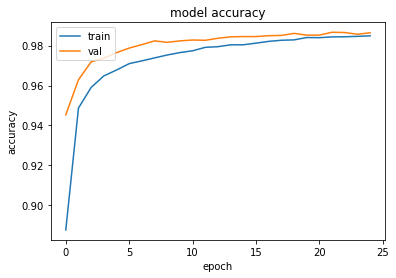

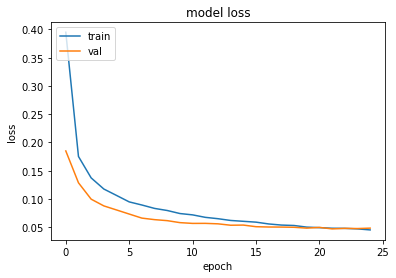

In [18]:
model_cnn_short = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D (2,2),

    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_short.summary()
predict_model(model_cnn_short, [es], epochs=100)

<font size=4>Next model has only 1 convolution layer which has more parameters (54,410) because of less number of pooling layers. The results are satisfying, but not as good as previous model (test accuracy equals 98,2%).

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 23, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 17, 17, 512)     

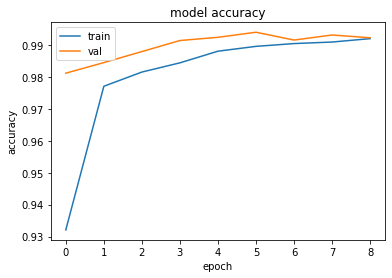

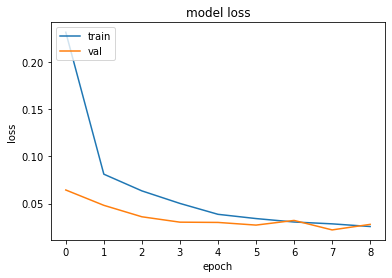

In [67]:
model_cnn_long = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D ((2,2),1),  
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D ((2,2),1), 
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D ((2,2),1),  
    layers.Conv2D(512, (3,3), activation="relu"),
    layers.MaxPooling2D ((2,2),1), 

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_long.summary()
predict_model(model_cnn_long, [es], epochs=100)

<font size=4>Next we created a neural network with 4 convolutional layers and with 17 milion parameters. The model was not overfitted. It had accuracy around 99.2% for test, train and validation model. Time needed to train this model was much higher (19s per epoch comparing to 3s per epoch in CNN that we have implemented). This is the best model that we have created for this dataset.

### Different number of filters per layer

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 4)         40        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 16)        592       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 400)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)               

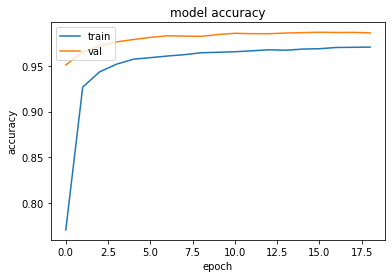

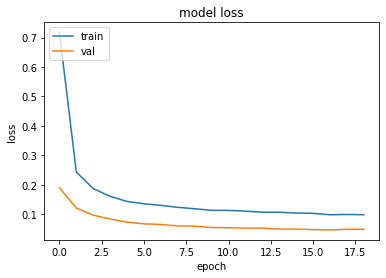

In [21]:
model_cnn_min = keras.Sequential([
    layers.Conv2D(4, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D (2,2),  
    layers.Conv2D(16, (3,3), activation="relu"),
    layers.MaxPooling2D (2,2),   

    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_min.summary()
predict_model(model_cnn_min, [es], epochs=100)

<font size=4>Next we decided to check how number of filters impact to performance of model. Reducing number of filter in convolutional layers made our model worse than basic model. Accuracy has fallen to 97.8%, because this model was too simple to explain complexity of our data. This model is underfitted.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 512)       590336    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)              

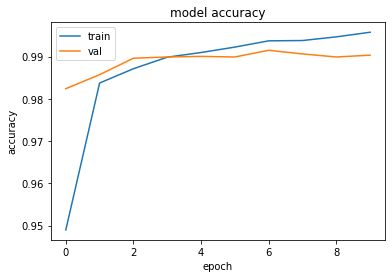

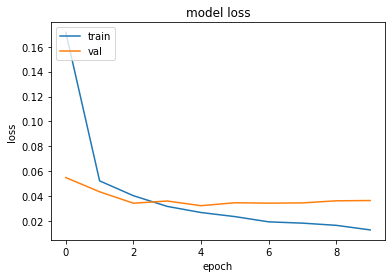

In [22]:
model_cnn_max = keras.Sequential([
    layers.Conv2D(128, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D (2,2),  
    layers.Conv2D(512, (3,3), activation="relu"),
    layers.MaxPooling2D (2,2),   

    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_max.summary()
predict_model(model_cnn_max, [es], epochs=100)

<font size=4>Next we increased number of filters. This caused a raise of number of parameters to over 700 thousands but model did not perform better than basic model. Test accuracy was 99%, which is slightly less than basic model's accuracy. It means that we should not use such high number of filters because we do not need them. This model also seems to be overfitted.

### Different size and type of pooling layers

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)              

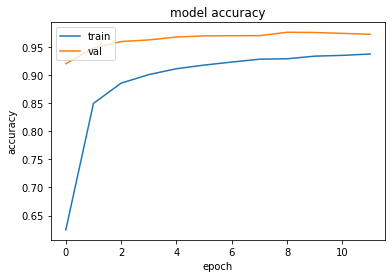

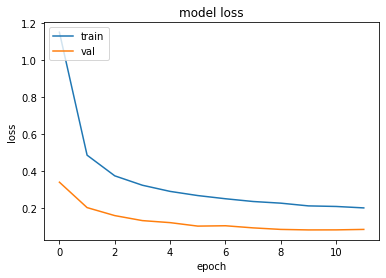

In [41]:
model_cnn_pool5 = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D (5,3),  
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D (5,3),   

    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_pool5.summary()
predict_model(model_cnn_pool5, [es], epochs=100)

<font size=4>Next, we checked different size of pooling layers. We decided to create a MaxPooling layers with size equals (5,5) and stride equals 3. It means that we take a square of values with size 5x5 then we look for max value, we write it in the middle of square and than we "move" 3 numbers in right or down direction. As we can see, the accuracy is worse than basic model, because we lose too much information in MaxPooling layers. The plots also shows that this model is underfitted.

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)              

Epoch 00031: early stopping
Test loss: 0.05266290158033371
Test accuracy: 0.9857142567634583
Test precision: 0.9866762161254883
Test recall: 0.9838571548461914
Test f1 score: 0.9857142857142858
Test AUC for digit: 0 0.9975965630331252
Test AUC for digit: 1 0.9964337348028355
Test AUC for digit: 2 0.9899322237602509
Test AUC for digit: 3 0.9902563737312167
Test AUC for digit: 4 0.993108146858049
Test AUC for digit: 5 0.992317975361152
Test AUC for digit: 6 0.9943650793650793
Test AUC for digit: 7 0.9950732539562421
Test AUC for digit: 8 0.9821428571428572
Test AUC for digit: 9 0.9892405775544455


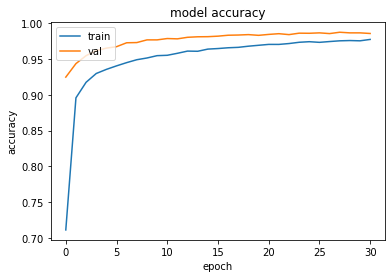

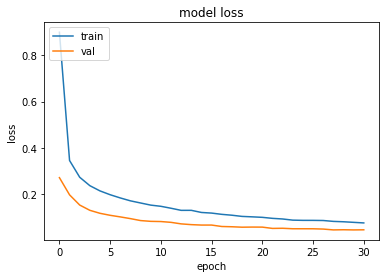

In [42]:
model_cnn_avg = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.AveragePooling2D (3,3),  
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.AveragePooling2D (3,3),   

    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_avg.summary()
predict_model(model_cnn_avg, [es], epochs=100)

<font size=4>After, we changed MaxPooling layer to AveragePooling layer. The difference between this two layers is that AveragePooling layer sums the values in the square and divides by the number of values in square. Results are worse than basic model because MaxPooling, by its characteristics, is better when we have black background, because it remembers the most white value in grey-scale. 

### Different number of full conected layers

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_57 (Dense)             (None, 32)              

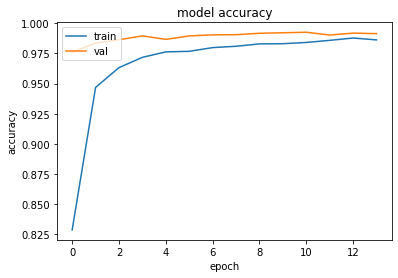

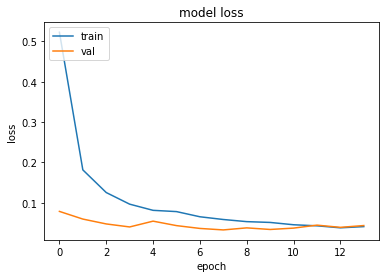

In [44]:
model_cnn_fc = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    layers.MaxPooling2D (2,2),  
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D (2,2),   

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dropout(.5),
    layers.Dense(10, activation="softmax")
])
model_cnn_fc.summary()
predict_model(model_cnn_fc, [es], epochs=100)

## The performance of a published network (LeNet5, VGG, Yolo, etc) for recognizing MNIST Digits

<font size=4>We decided to implement the architecture of LeNet5 network. The LeNet-5 architecture consists of two sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier.

### LeNet5

<font size=4>This is an implementation of LeNet5 (slightly different, because input shape is 28x28 and in original version was 32x32). Despite of its age the model is pretty accurate (with accuracy 98.9%). This is close to our best models, and it does not have too big number of parameters (only 60,074).

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_12 (Averag (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_83 (Dense)             (None, 84)              

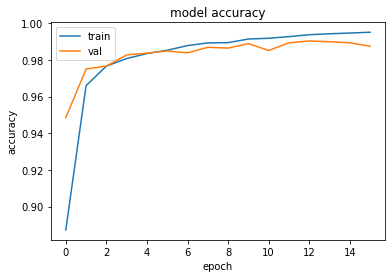

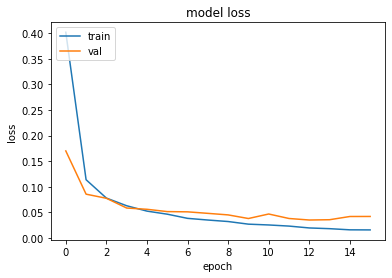

In [66]:
lenet5 = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
    layers.AveragePooling2D(),
    
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.AveragePooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(units=120, activation='relu'),
    layers.Dense(units=84, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

lenet5.summary()
predict_model(lenet5, [es], epochs=100)

### The best network 

In [117]:
from sklearn.metrics import confusion_matrix

y_pred = model_cnn_long.predict(x_test)
y_pred1 = list(np.argmax(y_pred, axis=1))
y_test1 = list(np.argmax(y_test, axis = 1))

confusion_matrix = confusion_matrix(y_test1, y_pred1)

print(confusion_matrix)

[[654   0   0   0   0   0   0   0   0   0]
 [  0 765   0   0   0   0   0   1   0   1]
 [  1   1 697   1   0   0   0   3   1   0]
 [  0   0   0 707   0   0   0   2   0   0]
 [  0   0   0   0 670   0   1   0   0   2]
 [  1   1   0   0   0 648   0   0   0   2]
 [  1   0   0   1   0   1 697   0   0   0]
 [  0   0   0   0   0   1   0 745   0   0]
 [  0   0   0   1   0   0   0   0 683   2]
 [  0   1   0   0   3   1   0   1   0 703]]


<font size=4>We chose model with best accuracy. It was a model with 4 convolutional layers and this is confusion matrix of this model.